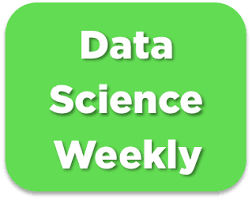

# Challenge : predict conversions 🏆🏆


# Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

# Read file with labels

In [2]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


# Explore dataset

In [3]:
print(f'There is {data.shape[0]} rows and {data.shape[1]} columns in this dataset')
print(f'Columns in this dataset {list(data.columns)}')
print(f'Overall missing values: \n{100*data.isnull().sum()/data.shape[0]}')

There is 284580 rows and 6 columns in this dataset
Columns in this dataset ['country', 'age', 'new_user', 'source', 'total_pages_visited', 'converted']
Overall missing values: 
country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64


In [4]:
#No missing values, we can definitely go further therefore without needing to clear out the data

In [5]:
data.corr()

,age,new_user,total_pages_visited,converted
age,1.000000,0.011676,-0.045365,-0.088265
new_user,0.011676,1.000000,-0.082986,-0.152115
total_pages_visited,-0.045365,-0.082986,1.000000,0.529192
converted,-0.088265,-0.152115,0.529192,1.000000


In [6]:
#visible corr can be total_pages_visited and the conversion rate, which is quite logical.

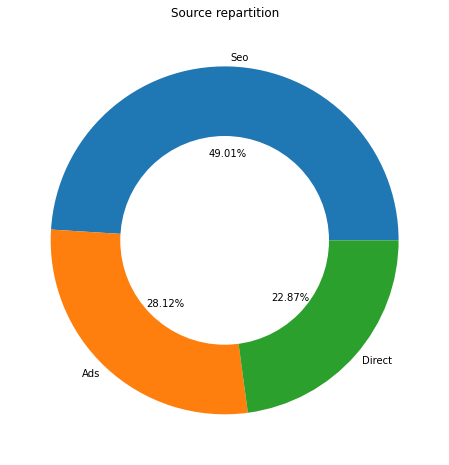

In [7]:
plt.figure(figsize=(16,8))
data.source.value_counts(dropna=False).plot(kind='pie',autopct='%1.2f%%',pctdistance=0.50, labeldistance=1.05)
plt.title('Source repartition')
plt.ylabel("")
centre_circle = plt.Circle((0,0),0.60,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

In [8]:
print(data["source"].value_counts())
print(data["country"].value_counts())

Seo       139477
Ads        80027
Direct     65076
Name: source, dtype: int64
US         160124
China       69122
UK          43641
Germany     11693
Name: country, dtype: int64


In [9]:
data.groupby(['country','converted'])['total_pages_visited'].describe()

count       mean       std  min   25%   50%   75%   max
country converted                                                            
China   0           69033.0   4.539206  2.783170  1.0   2.0   4.0   6.0  20.0
        1              89.0  14.168539  3.526639  6.0  12.0  14.0  16.0  26.0
Germany 0           10963.0   4.579951  2.796489  1.0   2.0   4.0   6.0  18.0
        1             730.0  14.634247  4.113170  2.0  12.0  15.0  17.0  27.0
UK      0           41350.0   4.555284  2.795250  1.0   2.0   4.0   6.0  19.0
        1            2291.0  14.531209  3.935424  2.0  12.0  14.0  17.0  27.0
US      0          154054.0   4.551930  2.791993  1.0   2.0   4.0   6.0  19.0
        1            6070.0  14.567710  3.956379  2.0  12.0  15.0  17.0  29.0

Text(0.5, 1.0, 'average number of pages to conversion in the data')

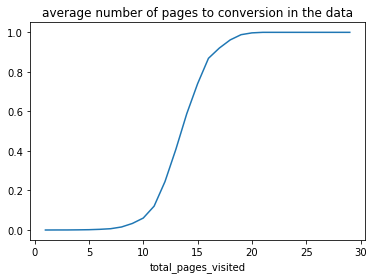

In [10]:
data.groupby(['total_pages_visited'])['converted'].mean().plot()
plt.title("average number of pages to conversion in the data")

In [11]:
#We can notice that to hit the 50% conversion we need the visitor to go through at least 14 pages

In [12]:
data.describe()

,age,new_user,total_pages_visited,converted
count,284580.000000,284580.000000,284580.000000,284580.000000
mean,30.564203,0.685452,4.873252,0.032258
std,8.266789,0.464336,3.341995,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [13]:
#The oldest converted person would have 123 years old, that's quite strange no?

In [14]:
#We can proceed with all features encoding 

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB


# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [16]:
features_list = ['age','new_user','total_pages_visited']
numeric_indices = [0]
categorical_indices = []
target_variable = 'converted'

In [17]:
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()
print("Separating labels from features...")
print("Target")
print(Y[:5,])

print("\nFeatures")
print(X)

Explanatory variables :  Index(['age', 'new_user', 'total_pages_visited'], dtype='object')

Separating labels from features...
Target
0    0
1    0
2    1
3    0
4    0
Name: converted, dtype: int64

Features
        age  new_user  total_pages_visited
0        22         1                    2
1        21         1                    3
2        20         0                   14
3        23         1                    3
4        28         1                    3
...     ...       ...                  ...
284575   36         1                    1
284576   31         1                    2
284577   41         1                    5
284578   31         1                    4
284579   26         0                    3

[284580 rows x 3 columns]


In [18]:
# Divide dataset Train set & Test set (80/20%) 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [19]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values
print("...Done")

print(X_train[0:5,:])
print(X_test[0:2,:])
print()
print(Y_train[0:5])
print(Y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done
[[20  0  6]
 [31  1  1]
 [32  0  2]
 [27  0  6]
 [23  0  2]]
[[28  0  3]
 [19  0  1]]

[0 0 0 0 0]
[0 0]


## Training pipeline

In [20]:
# pipeline for numeric features
numeric_features = [0,2]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])


# Create pipeline for categorical features
categorical_features = [1]
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

In [21]:
# preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [22]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train[0:5,:])
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5,:])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test[0:5,:])
X_test = preprocessor.transform(X_test) 
print('...Done.')
print(X_test[0:5,:])
print()

Performing preprocessings on train set...
[[20  0  6]
 [31  1  1]
 [32  0  2]
 [27  0  6]
 [23  0  2]]
...Done.
[[-1.27921531  0.33760267  0.        ]
 [ 0.0531415  -1.15994769  1.        ]
 [ 0.17426484 -0.86043762  0.        ]
 [-0.43135189  0.33760267  0.        ]
 [-0.91584527 -0.86043762  0.        ]]

Performing preprocessings on test set...
[[28  0  3]
 [19  0  1]
 [28  1  5]
 [22  1  7]
 [27  1  7]]
...Done.
[[-0.31022854 -0.56092754  0.        ]
 [-1.40033865 -1.15994769  0.        ]
 [-0.31022854  0.0380926   1.        ]
 [-1.03696861  0.63711275  1.        ]
 [-0.43135189  0.63711275  1.        ]]



In [23]:
# Train model
print("Train model...")
classifier = LogisticRegression() 
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [53]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 1]



## Performance assessment logistic regression

In [54]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7412243643905061
f1-score on test set :  0.7414104882459313


In [55]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[219470    872]
 [  2497   4825]]

Confusion matrix on test set : 
[[54828   230]
 [  628  1230]]



In [89]:
joblib.dump(classifier, './models/linearreg.pkl')

['./models/linearreg.pkl']

# RandomForestClassifier

In [93]:
model_2 = Pipeline(steps=[('preprocessing', preprocessor),
                      ('classifier', RandomForestClassifier())])

parameters = {'classifier__n_estimators': [200],
              'classifier__max_features': [3, 5, 10],
              'classifier__max_depth' : [15],}
gridsearch_param_randforest = GridSearchCV(model_2, param_grid = parameters, n_jobs = 2, cv = 4, verbose = 2)

gridsearch_param_randforest.fit(X_train, Y_train)
gridsearch_param_randforest.best_params_

#Instanciate our estimator to get the score according to documentation 
opti_randforest = gridsearch_param_randforest.best_estimator_
print(f'Best parameter was:{opti_randforest}')
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print('We have a score on training set at', opti_randforest.score(X_train, Y_train))
print('We have a score on testing set at', opti_randforest.score(X_test, Y_test))
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print('--------------------')
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))

Fitting 4 folds for each of 3 candidates, totalling 12 fits


/Users/reffet/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning:

One or more of the test scores are non-finite: [nan nan nan]



Best parameter was:Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  [0, 2]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  [1])])),
      

/Users/reffet/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/reffet/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/reffet/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/reffet/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "/Users/reffet/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 618, in score
    Xt = transform.transform(Xt)
  File "/Users/reffet/opt/anaconda3/lib/python3.8/site-packages/sklearn/compose/_c

[CV] END classifier__max_depth=15, classifier__max_features=3, classifier__n_estimators=200; total time=  14.3s
[CV] END classifier__max_depth=15, classifier__max_features=3, classifier__n_estimators=200; total time=  14.6s
[CV] END classifier__max_depth=15, classifier__max_features=5, classifier__n_estimators=200; total time=  13.4s
[CV] END classifier__max_depth=15, classifier__max_features=5, classifier__n_estimators=200; total time=  12.9s
[CV] END classifier__max_depth=15, classifier__max_features=10, classifier__n_estimators=200; total time=  14.4s
[CV] END classifier__max_depth=15, classifier__max_features=10, classifier__n_estimators=200; total time=  14.5s
[CV] END classifier__max_depth=15, classifier__max_features=3, classifier__n_estimators=200; total time=  14.5s
[CV] END classifier__max_depth=15, classifier__max_features=3, classifier__n_estimators=200; total time=  14.0s
[CV] END classifier__max_depth=15, classifier__max_features=5, classifier__n_estimators=200; total tim

In [88]:
joblib.dump(gridsearch_param_randforest, './models/randomforestclass.pkl')

['./models/randomforestclass.pkl']

# ExtratreesClassifier

In [92]:
model_3 = ExtraTreesClassifier(n_estimators = 150,max_depth=15)


gridsearch_param_xtratrees = model_3
gridsearch_param_xtratrees.fit(X_train, Y_train)

print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print('We have a score on training set at', gridsearch_param_xtratrees.score(X_train, Y_train))
print('We have a score on testing set at', gridsearch_param_xtratrees.score(X_test, Y_test))
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print('--------------------')
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))

f1-score on train set :  0.7412243643905061
f1-score on test set :  0.7414104882459313
We have a score on training set at 0.9855752336777005
We have a score on testing set at 0.9846791763300302
Confusion matrix on train set : 
[[219470    872]
 [  2497   4825]]
--------------------
Confusion matrix on test set : 
[[54828   230]
 [  628  1230]]


In [ ]:
#There's a slight improvement 0.001, maybe it could be increased with a proper gridsearch on ExtraTrees

We'll save the ExtraTreesClassifier as it seems to be the best performing model

In [76]:
joblib.dump(gridsearch_param_xtratrees, './models/extratreesclassifier.pkl')

['./models/extratreesclassifier.pkl']

# Lets try it out on our test set now

Load the model 

In [80]:
extratree = joblib.load('./models/extratreesclassifier.pkl')

In [81]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

extratree.fit(X,Y)

ExtraTreesClassifier(max_depth=15, n_estimators=150)

_Load the dataset without labels_

In [82]:
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

Prediction set (without labels) : (31620, 5)


In [83]:
# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list = ['age','new_user','total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

Convert pandas DataFrames to numpy arrays...
...Done
[[28  0 16]
 [22  1  5]
 [32  1  1]
 [32  1  6]
 [25  0  3]]


In [85]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.31022854  3.3327034   0.        ]
 [-1.03696861  0.0380926   1.        ]
 [ 0.17426484 -1.15994769  1.        ]
 [ 0.17426484  0.33760267  1.        ]
 [-0.67359858 -0.56092754  0.        ]]


# Convert our predictions to a csv to be able to submit

In [87]:
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_anatole_modelxtratree.csv', index = False)